In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Get object points and image points
def get_points(chess_board_images, section_per_row, section_per_col, verbose=False):
    
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0), ....
    objp = np.zeros([section_per_col * section_per_row, 3], dtype='float32')
    objp[:,:2] = np.mgrid[:section_per_row, :section_per_col].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.




    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(chess_board_images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (section_per_row, section_per_col), None)

        # If found, add object points, image points
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

            if verbose:
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (section_per_row, section_per_col), corners, ret)
                plt.imshow(img)
                plt.show()
    return (objpoints, imgpoints)

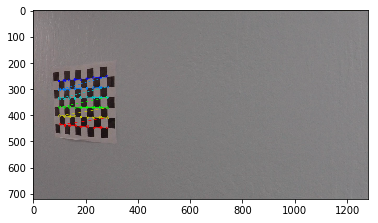

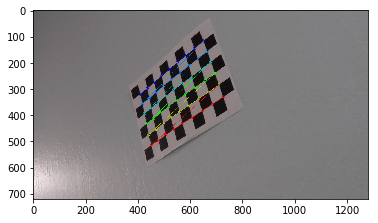

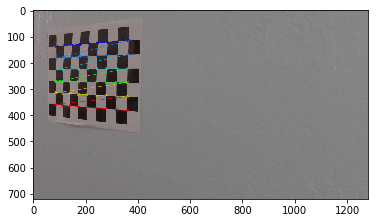

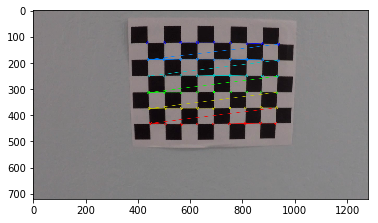

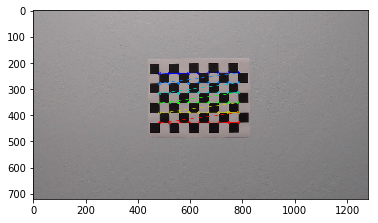

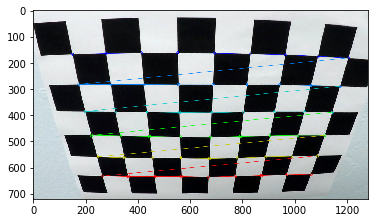

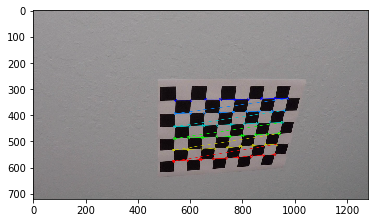

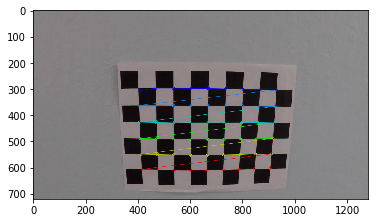

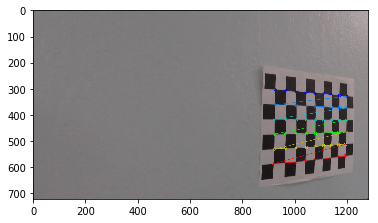

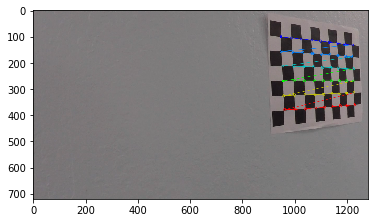

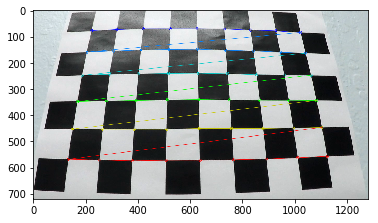

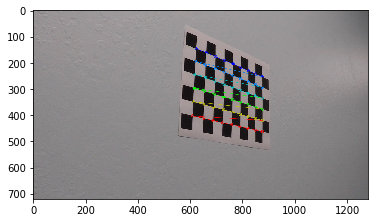

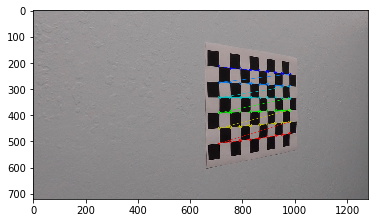

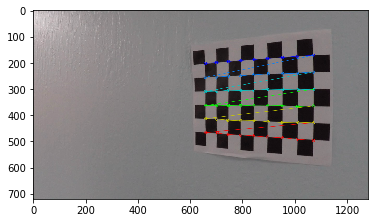

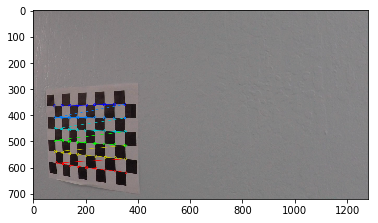

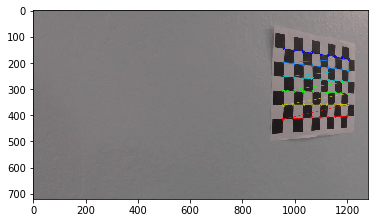

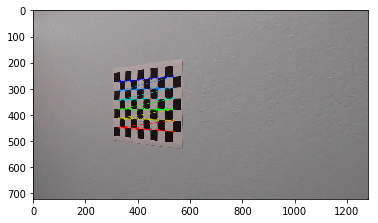

In [2]:
import glob

# Make a list of calibration images
chess_board_images = glob.glob('camera_cal/calibration*.jpg')
objpoints, imgpoints = get_points(chess_board_images, section_per_row=9, section_per_col=6, verbose=True)

In [3]:
import pickle

# Read in a test image
image = cv2.cvtColor(cv2.imread('test_images/test2.jpg'), cv2.COLOR_BGR2RGB)

In [4]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[:2], None, None)

# Save calibration parameters in a dictionary
camera_calibration = {
    'ret' : ret, 
    'mtx' : mtx, 
    'dist' : dist,
    'rvecs' : rvecs,
    'tvecs' : tvecs
}

# Save the calibration parameters into a file, so we don't have to calculate them everytime
with open('camera_calibration.pkl', 'wb') as f:
    pickle.dump(camera_calibration, f, pickle.HIGHEST_PROTOCOL)


In [5]:
ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)

# Read in calibration parameters
with open('camera_calibration.pkl', 'rb') as f:
    pickle_data = pickle.load(f)
    ret = pickle_data['ret']
    mtx = pickle_data['mtx']
    dist = pickle_data['dist']
    rvecs = pickle_data['rvecs']
    tvecs = pickle_data['tvecs']

# Undistort the image
def undistort_image(img, mtx, dist, verbose=False):
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    if verbose:
        plt.figure(figsize=(10, 10))
        plt.imshow(img_undist)
        plt.title('Undistored Image', fontsize=30)
        plt.show()
    return img_undist

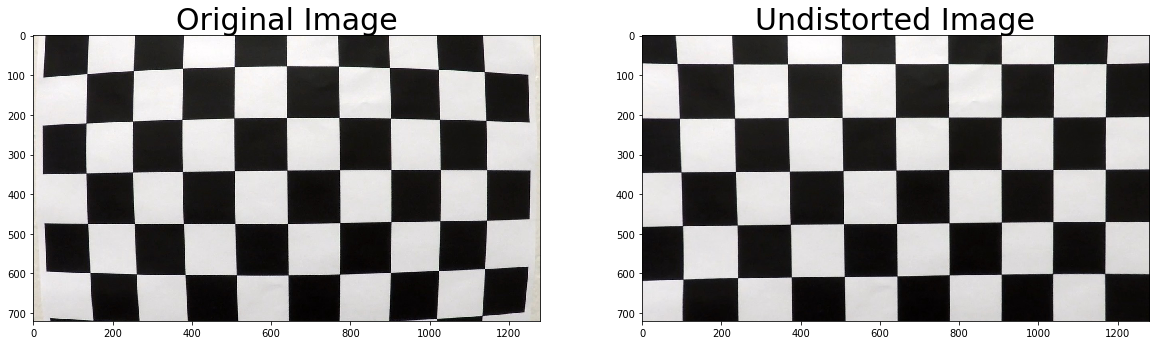

In [6]:
test_image = cv2.cvtColor(cv2.imread('camera_cal/calibration1.jpg'), cv2.COLOR_BGR2RGB)

test_image_undist = undistort_image(test_image, mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_image_undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

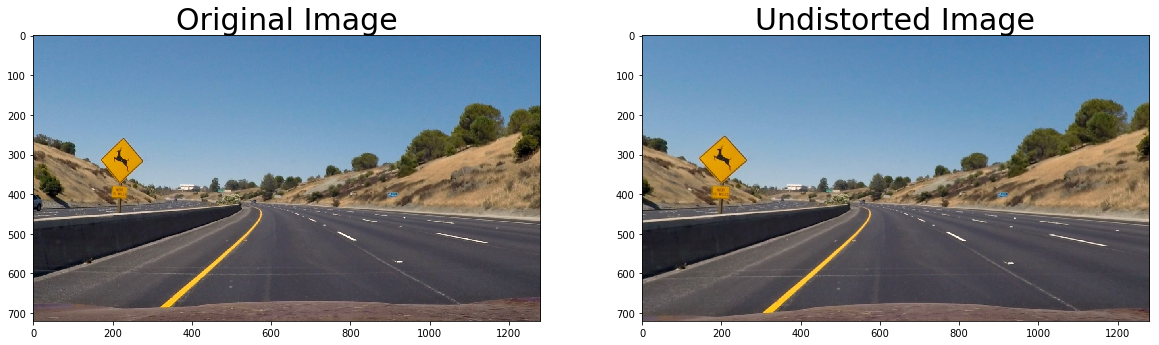

In [7]:
image_undist = undistort_image(image, mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

In [8]:
def thresholded_binary(img, verbose=False):
    
    # Note: img is the undistorted image
    # Convert to Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # HLS Channel
    h_channel = hls[:, :, 0]
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    # Sobel operation on x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx_abs = np.abs(sobelx)
    
    # Sobel operation on y
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobely_abs = np.abs(sobely)
    
    # Scale the gradient to [0, 255]
    sobelx_scaled = 255 * (sobelx_abs / np.max(sobelx_abs))
    sobely_scaled = 255 * (sobely_abs / np.max(sobely_abs))
    
    # Magnitude of gradient
    sobelxy_scaled = (sobelx_scaled ** 2 + sobely_scaled ** 2) ** 0.5
    
    # Direction of gradient
    rad = np.arctan2(sobely_abs, sobelx_abs)
    
    # Thresholded binary for HLS
    h_binary = (21 <= h_channel) & (h_channel <= 24)
    l_binary = (200 <= l_channel) & (l_channel <= 255)
    s_binary = (100 <= s_channel) & (s_channel <= 255)
    
    # Thresholded binary for gradient
    sobelx_binary = (30 <= sobelx_scaled) & (sobelx_scaled <= 255)
    sobely_binary = (30 <= sobely_scaled) & (sobely_scaled <= 255)
    sobelxy_binary = (60 <= sobelxy_scaled) & (sobelxy_scaled <= 255)
    sobel_rad_binary = (0.8 <= rad) & (rad <= 1.3)
    
    # Combined thresholded binary
    binary1 = sobelxy_binary & sobel_rad_binary
    binary2 = sobelx_binary & sobely_binary
    binary3 = (h_binary | l_binary) & s_binary
    combined_binary = binary1 | binary2 | binary3
    
    
    combined_binary = combined_binary.astype('uint8') * 255
    combined_binary = np.dstack((combined_binary, combined_binary, combined_binary))
    
    if verbose:
        plt.figure(figsize=(10, 10))
        plt.imshow(combined_binary)
        plt.title('Combined Thresholded Binary', fontsize=30)
        plt.show()
        
    
    return combined_binary

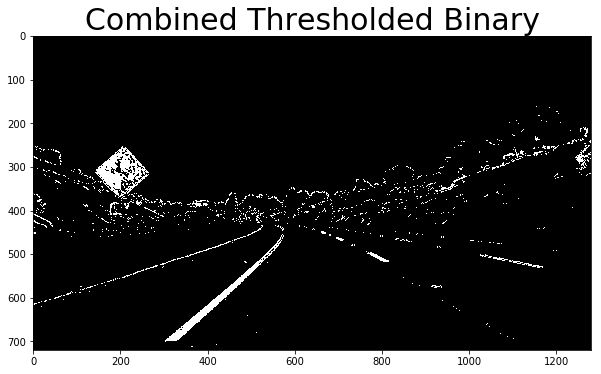

In [9]:
image_undist_binary = thresholded_binary(image_undist, verbose=True)

In [10]:
# Outer points of the trapezoid
src_outer_points = np.float32([[140, image.shape[0]], [1200, image.shape[0]], [800, 480], [520, 480]])
# inner points of the trapezoid
src_inner_points = np.float32([[360, image.shape[0]], [980, image.shape[0]], [660, 480], [660, 480]])
# Perspective transformed points of trapezoid
dst_points = np.float32([[500, image.shape[0]], [900, image.shape[0]], [900, 0], [500, 0]])

# Perspective Transform Matrix
transform_M = cv2.getPerspectiveTransform(src_outer_points, dst_points)
# Inverse of Perspective Transform Matrix
transform_M_inv = cv2.getPerspectiveTransform(dst_points, src_outer_points)

In [11]:
src_outer_points_x = src_outer_points.T[0]
src_outer_points_y = src_outer_points.T[1]
src_inner_points_x = src_inner_points.T[0]
src_inner_points_y = src_inner_points.T[1]

# Outer and inner lines of the trapezoid
fit_bottom = np.polyfit([src_outer_points_x[0], src_outer_points_x[1]], 
                        [src_outer_points_y[0], src_outer_points_y[1]], 1)
fit_right_outer = np.polyfit([src_outer_points_x[1], src_outer_points_x[2]], 
                             [src_outer_points_y[1], src_outer_points_y[2]], 1)
fit_top = np.polyfit([src_outer_points_x[2], src_outer_points_x[3]], 
                     [src_outer_points_y[2], src_outer_points_y[3]], 1)
fit_left_outer = np.polyfit([src_outer_points_x[3], src_outer_points_x[0]], 
                            [src_outer_points_y[3], src_outer_points_y[0]], 1)
fit_left_inner = np.polyfit([src_inner_points_x[3], src_inner_points_x[0]], 
                            [src_inner_points_y[3], src_inner_points_y[0]], 1)
fit_right_inner = np.polyfit([src_inner_points_x[1], src_inner_points_x[2]], 
                             [src_inner_points_y[1], src_inner_points_y[2]], 1)

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, image.shape[1]), np.arange(0, image.shape[0]))
filter1 = (YY > (XX * fit_left_outer[0] + fit_left_outer[1])) & \
            (YY < (XX * fit_left_inner[0] + fit_left_inner[1]))
filter2 = (YY > (XX * fit_right_outer[0] + fit_right_outer[1])) & \
            (YY < (XX * fit_right_inner[0] + fit_right_inner[1]))
filter3 = (YY < (XX * fit_bottom[0] + fit_bottom[1])) & \
            (YY > (XX * fit_top[0] + fit_top[1]))
region_thresholds = (filter1 | filter2) & filter3
            
region_thresholds = ~region_thresholds

In [12]:
def masked_image(img, region_thresholds):
    img_masked = img.copy()
    img_masked[region_thresholds] = 0
    return img_masked

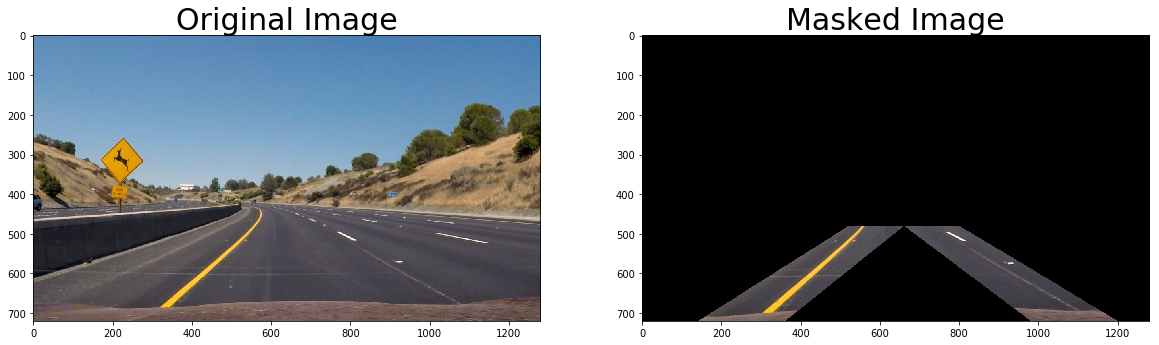

In [13]:
image_masked = masked_image(image_undist, region_thresholds)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_masked)
ax2.set_title('Masked Image', fontsize=30)
plt.show()

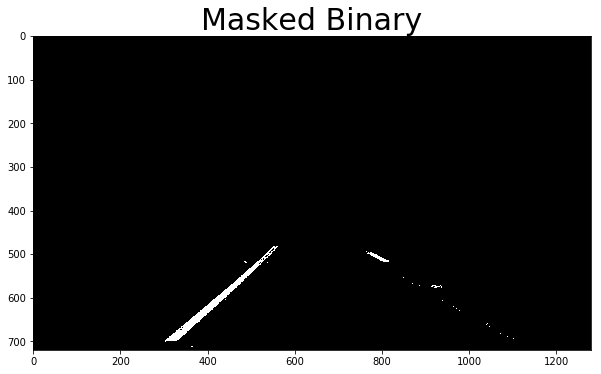

In [14]:
image_undist_binary_masked = masked_image(image_undist_binary, region_thresholds)

plt.figure(figsize=(10, 10))
plt.imshow(image_undist_binary_masked)
plt.title('Masked Binary', fontsize=30)
plt.show()

In [15]:
def perspective_transform(img, M):
    img_size = (img.shape[1], img.shape[0])
    img_warped = cv2.warpPerspective(img, M, img_size)
    
    return img_warped

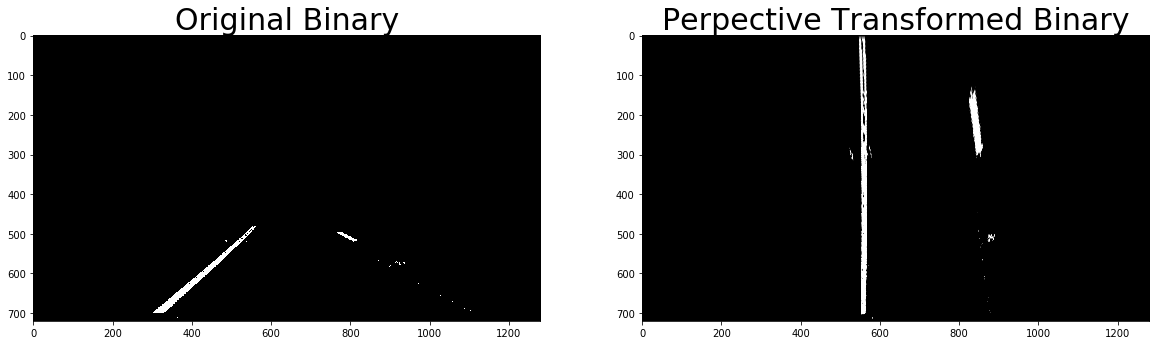

In [16]:
image_undist_binary_masked_transformed = perspective_transform(image_undist_binary_masked, transform_M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image_undist_binary_masked)
ax1.set_title('Original Binary', fontsize=30)
ax2.imshow(image_undist_binary_masked_transformed)
ax2.set_title('Perpective Transformed Binary', fontsize=30)
plt.show()

In [17]:
class Line:
    def __init__(self, liney, linex, fit, fity, fitx, r_curve):
        self.fit = fit             # Parameters of the parabola
        self.fity = fity           # y coordinate of points on the fitted line
        self.fitx = fitx           # x coordinate of points on the fitted line
        self.liney = liney         # y coordinate of points on the real line
        self.linex = linex         # x coordinate of points on the real line
        self.r_curve = r_curve     # Curvature radius of the fitted line in meters

In [18]:
ny = 30 / (dst_points[1][1] - dst_points[2][1])  # meters per pixel in y dimension
nx = 3.7 / (dst_points[1][0] - dst_points[0][0]) # meters per pixel in x dimension


def calculate_polynomial(y_value, fit):
    A, B, C = fit
    return A * y_value ** 2 + B * y_value + C

# Calculate curvature radius in meters
def calculate_r_curve(y_value, fity, fitx, ny, nx):
    A, B, C = np.polyfit(fity * ny, fitx * nx, 2).astype('float32')
    real_y_value = y_value * ny
    dx_dy = 2 * A * real_y_value + B
    dx_dy_2 = 2 * A
    r_curve = (1 + dx_dy ** 2) ** 1.5 / abs(dx_dy_2)
    return r_curve

In [19]:
# Find lane line from scratch
def find_lane_line_from_scratch(img, verbose=False):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0] // 2:, :, 0], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = img.copy()

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = histogram.shape[0] // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = img.shape[0] // nwindows
    # Set the width of the windows +/- margin
    margin = 50
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = nonzero[0].copy()
    nonzerox = nonzero[1].copy()
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set minimum number of pixels found to recenter window
    minpix = 100

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((win_y_low <= nonzeroy) & (nonzeroy < win_y_high) & 
        (win_xleft_low <= nonzerox) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((win_y_low <= nonzeroy) & (nonzeroy < win_y_high) & 
        (win_xright_low <= nonzerox) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.mean(nonzerox[good_left_inds]).astype('int32')
        if len(good_right_inds) > minpix:        
            rightx_current = np.mean(nonzerox[good_right_inds]).astype('int32')

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    
    left_line = None
    right_line = None

    if len(left_lane_inds) > 0:
        
        # Extract left line pixel positions
        left_liney = nonzeroy[left_lane_inds]
        left_linex = nonzerox[left_lane_inds]

        # Fit a second order polynomial
        left_fit = np.polyfit(left_liney, left_linex, 2).astype('float32')

        # Generate x and y values for plotting
        left_fity = np.linspace(0, img.shape[0] - 1, img.shape[0], dtype='float32')
        left_fitx = calculate_polynomial(left_fity, left_fit)
        
        # Calculate radius of curvature
        left_r_curve = calculate_r_curve(img.shape[0], left_fity, left_fitx, ny, nx)
        
        left_line = Line(left_liney, left_linex, left_fit, left_fity, left_fitx, left_r_curve)

        out_img[left_liney, left_linex] = (255, 0, 0)
        
    if len(right_lane_inds) > 0:

            # Extract left line pixel positions
            right_liney = nonzeroy[right_lane_inds]
            right_linex = nonzerox[right_lane_inds]

            # Fit a second order polynomial
            right_fit = np.polyfit(right_liney, right_linex, 2).astype('float32')

            # Generate x and y values for plotting
            right_fity = np.linspace(0, img.shape[0] - 1, img.shape[0], dtype='float32')
            right_fitx = calculate_polynomial(right_fity, right_fit)

            # Calculate radius of curvature
            right_r_curve = calculate_r_curve(img.shape[0], right_fity, right_fitx, ny, nx)

            right_line = Line(right_liney, right_linex, right_fit, right_fity, right_fitx, right_r_curve)

            out_img[right_liney, right_linex] = (0, 0, 255)

    
    if verbose:
        plt.figure(figsize=(10, 10))
        plt.plot(histogram)
        plt.title('Histogram of Binary Image', fontsize=30)
        plt.show()
        
        plt.figure(figsize=(10, 10))
        plt.imshow(out_img)
        if left_line is not None:
            plt.plot(left_line.fitx, left_line.fity, color='yellow')
        if right_line is not None:
            plt.plot(right_line.fitx, right_line.fity, color='yellow')
        plt.title('Polynomial', fontsize=30)
        plt.show()
    
    
    
    return left_line, right_line

In [20]:
# Find lane line along with the line found from last frame
def find_lane_line_from_last_frame(img, last_frame_left_line, last_frame_right_line, verbose=False):

    # Create an output image to draw on and  visualize the result
    out_img = img.copy()
    margin = 50
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = nonzero[0].copy()
    nonzerox = nonzero[1].copy()
    
    left_lane_inds = []
    right_lane_inds = []
    
    if last_frame_left_line is not None:
        left_lane_inds = ((nonzerox > (last_frame_left_line.fit[0] * (nonzeroy ** 2) + 
                                       last_frame_left_line.fit[1] * nonzeroy + 
                                        last_frame_left_line.fit[2] - margin)) & 
                          (nonzerox < (last_frame_left_line.fit[0] * (nonzeroy ** 2) + 
                                        last_frame_left_line.fit[1] * nonzeroy + 
                                       last_frame_left_line.fit[2] + margin))).nonzero()[0]

        
    if last_frame_right_line is not None:
        right_lane_inds = ((nonzerox > (last_frame_right_line.fit[0] * (nonzeroy ** 2) + 
                                        last_frame_right_line.fit[1] * nonzeroy + 
                                        last_frame_right_line.fit[2] - margin)) & 
                           (nonzerox < (last_frame_right_line.fit[0] * (nonzeroy ** 2) + 
                                        last_frame_right_line.fit[1] * nonzeroy + 
                                        last_frame_right_line.fit[2] + margin))).nonzero()[0]
    
    
    
    left_line = None
    right_line = None

    if len(left_lane_inds) > 0:
        
        # Extract left line pixel positions
        left_liney = nonzeroy[left_lane_inds]
        left_linex = nonzerox[left_lane_inds]

        # Fit a second order polynomial to each
        left_fit = np.polyfit(left_liney, left_linex, 2).astype('float32')

        # Generate x and y values for plotting
        left_fity = np.linspace(0, img.shape[0] - 1, img.shape[0], dtype='float32')
        left_fitx = calculate_polynomial(left_fity, left_fit)
        
        left_r_curve = calculate_r_curve(img.shape[0], left_fity, left_fitx, ny, nx)
        
        left_line = Line(left_liney, left_linex, left_fit, left_fity, left_fitx, left_r_curve)

        out_img[left_liney, left_linex] = (255, 0, 0)
        
    if len(right_lane_inds) > 0:

            # Extract left and right line pixel positions
            right_liney = nonzeroy[right_lane_inds]
            right_linex = nonzerox[right_lane_inds]

            # Fit a second order polynomial to each
            right_fit = np.polyfit(right_liney, right_linex, 2).astype('float32')

            # Generate x and y values for plotting
            right_fity = np.linspace(0, img.shape[0] - 1, img.shape[0], dtype='float32')
            right_fitx = calculate_polynomial(right_fity, right_fit)

            right_r_curve = calculate_r_curve(img.shape[0], right_fity, right_fitx, ny, nx)

            right_line = Line(right_liney, right_linex, right_fit, right_fity, right_fitx, right_r_curve)

            out_img[right_liney, right_linex] = (0, 0, 255)

    
    if verbose:
        if left_line is not None:
            print('left line', left_line.fit)
        else:
            print('left line not fountd')
        if right_line is not None:
            print('right line', right_line.fit)
        else:
            print('right line not found')
        
        plt.figure(figsize=(10, 10))
        plt.imshow(out_img)
        if left_line is not None:
            plt.plot(left_line.fitx, left_line.fity, color='yellow')
        if right_line is not None:
            plt.plot(right_line.fitx, right_line.fity, color='yellow')
        plt.title('Polynomial', fontsize=30)
        plt.show()
    
    return left_line, right_line

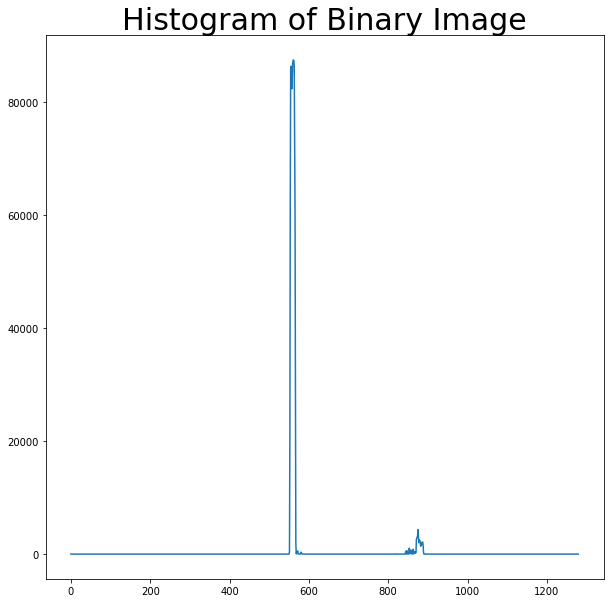

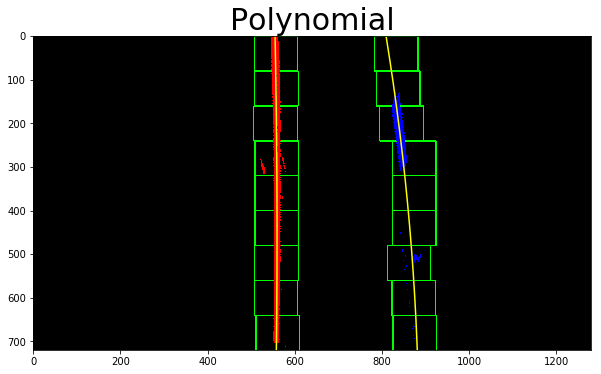

In [21]:
left_line, right_line = find_lane_line_from_scratch(image_undist_binary_masked_transformed, verbose=True)

In [22]:
# Map fitted lane line back to the original image
def color_image(img, left_line, right_line, verbose=False):
    if left_line is None or right_line is None:
        return img, None, None
        
    left_fity_int = left_line.fity.astype('int32')
    left_fitx_int = left_line.fitx.astype('int32')
    
    right_fity_int = right_line.fity.astype('int32')
    right_fitx_int = right_line.fitx.astype('int32')

    pts_left = np.transpose(np.vstack((left_fitx_int, left_fity_int)))
    pts_right = np.flipud(np.transpose(np.vstack((right_fitx_int, right_fity_int))))
    pts = np.vstack((pts_left, pts_right))


    color_trapezoid = np.zeros_like(img).astype('uint8')
    cv2.fillPoly(color_trapezoid, [pts], (0, 255, 0))


    color_trapezoid[left_line.liney, left_line.linex] = (255, 0, 0)
    color_trapezoid[right_line.liney, right_line.linex] = (0, 0, 255)

    color_trapezoid = perspective_transform(color_trapezoid, transform_M_inv)


    last_line_pos = color_trapezoid[-1].nonzero()[0]
    left_pos = last_line_pos[0] if len(last_line_pos) > 0 else -1
    right_pos = last_line_pos[-1] if len(last_line_pos) > 0 else -2


    img_color = cv2.addWeighted(img, 1, color_trapezoid, 0.3, 0)

    if verbose:
        plt.figure(figsize=(10, 10))
        plt.imshow(img_color)
        plt.title('Color Image', fontsize=30)
        plt.show()
    
    return img_color, left_pos, right_pos

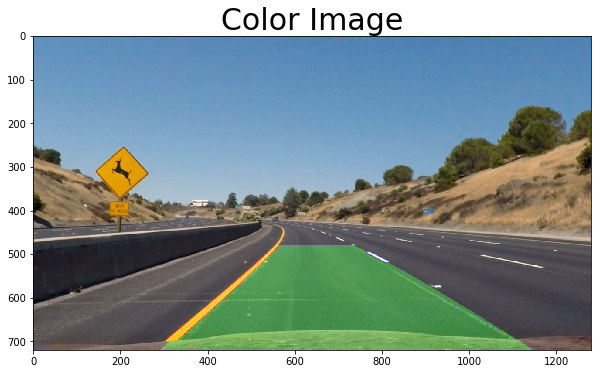

In [23]:
image_undist_color, left_pos, right_pos = color_image(image_undist, left_line, right_line, verbose=True)

In [24]:
# Draw lane line information on the image
def text_image(img, left_line, right_line, left_pos, right_pos, verbose=False):
    
    if left_line is None or right_line is None:
        img_text = img.copy()
        img_text = cv2.putText(img, 'Lane line not found', (0, 70), 
                                  cv2.FONT_HERSHEY_COMPLEX, 2, (255, 255, 255), 3)
        return img_text
    
    offset = nx * (img.shape[1] / 2 - (left_pos + right_pos) / 2)
    
    r_curve_text = 'Radius of Curvature = %.2f(m)' % np.minimum(left_line.r_curve, right_line.r_curve)
    direction_text = 'left' if offset < 0 else 'right'
    offset_text = 'Vehicle is %.2f(m) ' % np.abs(offset) + direction_text + ' of center'
    img_text = img.copy()
    img_text = cv2.putText(img_text, r_curve_text, (0, 70), 
                              cv2.FONT_HERSHEY_COMPLEX, 2, (255, 255, 255), 3)
    img_text = cv2.putText(img_text, offset_text, (0, 150), 
                              cv2.FONT_HERSHEY_COMPLEX, 2, (255, 255, 255), 3)

    if verbose:
        print('left R-curve', left_line.r_curve, 'm')
        print('right R-curve', right_line.r_curve, 'm')
        print('offset', offset, 'm')

        plt.figure(figsize=(10, 10))
        plt.imshow(img_text)
        plt.title('Text Result', fontsize=30)
        plt.show()
    
    return img_text

left R-curve 4224.012806660629 m
right R-curve 1083.9784132966467 m
offset -0.7307500000000001 m


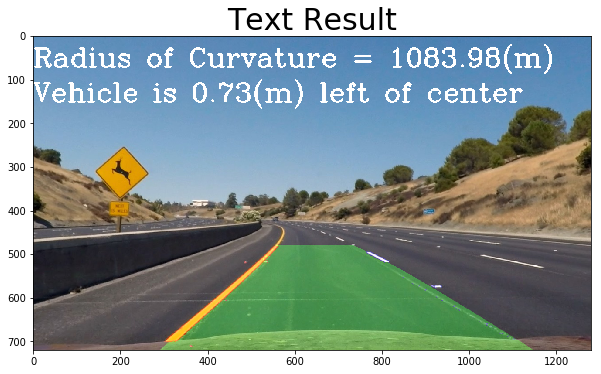

In [25]:
image_undist_color_text = text_image(image_undist_color, left_line, right_line, 
                                     left_pos, right_pos, verbose=True)

In [26]:
# Cache of recent lines
left_line_cache = []
right_line_cache = []

In [27]:
# Pipeline of lane line finding
def process_image(img, verbose=False):
    image_undist = undistort_image(img, mtx, dist, verbose=verbose)
    image_undist_binary = thresholded_binary(image_undist, verbose=verbose)
    image_undist_binary_masked = masked_image(image_undist_binary, region_thresholds)
    image_undist_binary_masked_transformed = perspective_transform(image_undist_binary_masked, transform_M) 

    
    last_frame_left_line = left_line_cache[-1] if len(left_line_cache) > 0 else None
    last_frame_right_line = right_line_cache[-1] if len(right_line_cache) > 0 else None
    
    
    # Try find lane line along with last found lane line
    left_line_last, right_line_last = find_lane_line_from_last_frame(image_undist_binary_masked_transformed, 
                                                                           last_frame_left_line, 
                                                                           last_frame_right_line, 
                                                                           verbose=verbose)
    
    
    # If not found, then try find lane line from scratch
    if left_line_last is None or right_line_last is None:
        left_line_scratch, right_line_scratch = find_lane_line_from_scratch( \
            image_undist_binary_masked_transformed, verbose=verbose)
    
    left_line = left_line_last if left_line_last is not None else left_line_scratch
    right_line = right_line_last if right_line_last is not None else right_line_scratch
    
    # Cache the recent n lines, and use their average as the current line
    if left_line is not None:
        left_line_cache.append(left_line)
        if len(left_line_cache) > 3:
            left_line_cache.pop(0)
        left_fit_cache = [line.fit for line in left_line_cache]
        left_line.fit = np.mean(left_fit_cache, axis=0)
        left_line.fitx = calculate_polynomial(left_line.fity, left_line.fit)
        left_line.r_curve = calculate_r_curve(img.shape[0], left_line.fity, left_line.fitx, ny, nx)
    
    if right_line is not None:
        right_line_cache.append(right_line)
        if len(right_line_cache) > 3:
            right_line_cache.pop(0)
        right_fit_cache = [line.fit for line in right_line_cache]
        right_line.fit = np.mean(right_fit_cache, axis=0)
        right_line.fitx = calculate_polynomial(right_line.fity, right_line.fit)
        right_line.r_curve = calculate_r_curve(img.shape[0], right_line.fity, right_line.fitx, ny, nx)
    
    
    image_undist_color, left_pos, right_pos = color_image(image_undist, left_line, right_line)
    image_undist_color_text = text_image(image_undist_color, left_line, right_line, left_pos, right_pos)
    
    return image_undist_color_text

In [28]:
from moviepy.editor import VideoFileClip

white_output = 'project_video_output.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, codec='h264', audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:25<00:00,  6.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 25min 50s, sys: 46.3 s, total: 26min 37s
Wall time: 3min 25s
